# Covid19 cases in US states

Here I'll copy some of what was done by Kevin Systrom in [this notebook](github.com/k-sys/covid-19/blob/master/Realtime%20R0.ipynb).  Specifically, we'll download state infection data from [covidtracking.com](covidtracking.com).

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


In [3]:
# The commands below extract just the cummulative number of positive cases

url = 'https://covidtracking.com/api/v1/states/daily.csv'   

states = pd.read_csv(url,
                     usecols=['date', 'state', 'positive','death'], # grab only these columns from CSV
                     parse_dates=['date'],                  # .. confusing 
                     index_col=['state', 'date'],           # use these as column labels
                     squeeze=True).sort_index()             # sort the data 

# Now 'states' is a pandas DataFrame, and all the states.<commands> are pandas commands

In [4]:
states

positive  death
state date                       
AK    2020-03-06       0.0    0.0
      2020-03-07       0.0    0.0
      2020-03-08       0.0    0.0
      2020-03-09       0.0    0.0
      2020-03-10       0.0    0.0
...                    ...    ...
WY    2020-05-11     662.0    7.0
      2020-05-12     675.0    7.0
      2020-05-13     675.0    7.0
      2020-05-14     701.0    7.0
      2020-05-15     715.0    7.0

[3993 rows x 2 columns]

In [20]:
state_name = 'NY'   # Check out our state first!

cases = states.xs(state_name).xs('positive',axis=1).rename(f"{state_name} cases")  # xs = cross-section.  Grabs data frame 
                                                             # matching index label 

In [21]:
cases

date
2020-03-04         6.0
2020-03-05        22.0
2020-03-06        33.0
2020-03-07        76.0
2020-03-08       105.0
                ...   
2020-05-11    337055.0
2020-05-12    338485.0
2020-05-13    340661.0
2020-05-14    343051.0
2020-05-15    345813.0
Name: NY cases, Length: 73, dtype: float64

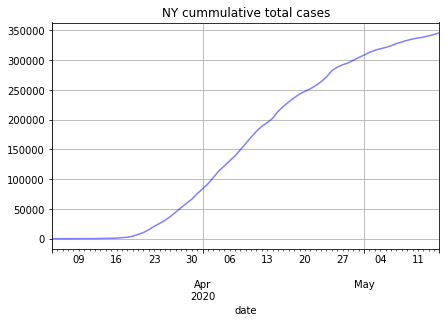

In [22]:
cases.plot(title=f"{state_name} cummulative total cases",
            c='b',
            alpha=.5,
            grid=True,
            figsize=(500/72, 300/72))


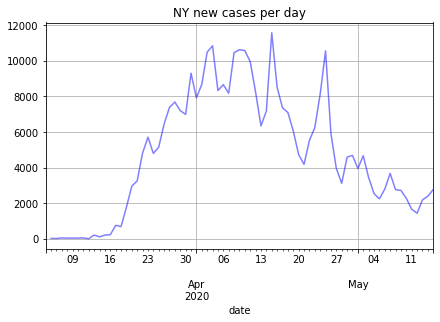

In [23]:
new_cases = cases.diff()   # compute the number of new cases per day:  basically,
                           # new_cases(i) = cases(i)-cases(i-1), and then new_cases(0) = NaN
    
new_cases.plot(title=f"{state_name} new cases per day",
               c='b',
               alpha=.5,
               grid=True,
               figsize=(500/72, 300/72))


In [24]:
# It's pretty noisy after computing difference.  Let's use a smoothing filter, and also remove the early days 
# when there are fewer than 25 new cases per day

def smooth_new_cases(new_cases, cutoff=25):
    # The function below does a "Gaussian rolling average" of the data. Basically it smooths out jumps in the data
    # the first argument -- '7' -- is the number of days over which to apply the average, i.e. filtered new_cases(i) 
    # is roughly an average over new_cases(i-3) to new_cases(i+3)
    
    new_cases_smoothed = new_cases.rolling(7, win_type='gaussian', min_periods=1,center=True).mean(std=2).round()
    
    # Ignore data before there are at least 25 new cases in a day
    idx_start = np.searchsorted(new_cases_smoothed, cutoff)     # Finds index where value in smoothed = cutoff
    new_cases_smoothed = new_cases_smoothed.iloc[idx_start:]
    
    return new_cases_smoothed,idx_start



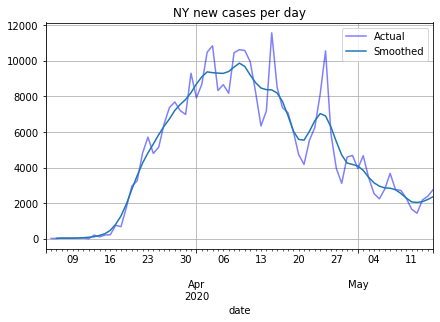

In [25]:
new_cases_smoothed,idx_start = smooth_new_cases(new_cases)

new_cases.plot(title=f"{state_name} new cases per day",
               c='b',
               alpha=.5,
               label='Actual',
               legend=True,
               grid=True,
               figsize=(500/72, 300/72))

ax2 = new_cases_smoothed.plot(
                    label='Smoothed',
                    grid=True,
                    legend=True)

#ax2.get_figure().set_facecolor('w')


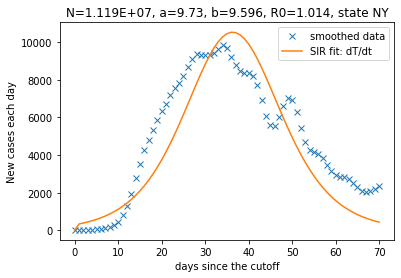

In [31]:
import scipy
newI = np.asarray(new_cases_smoothed)
newI = newI[~np.isnan(newI)]
t = np.arange(np.shape(newI)[0])

def SIR_deriv(X,t,N,a,b):
    S,I,R = X
    return -a/N*I*S, a/N*I*S-b*I, b*I


I0 = cases[idx_start]
R0 = 0
def SIR(t,N,a,b):
    X0 = N-I0-R0,I0,R0

    # Integrate the equations over the time grid, t.
    ret = scipy.integrate.odeint(SIR_deriv, X0, t, args=(N,a,b))
    S,I,R = ret.T
    return np.insert( np.diff(N - S),0,I0+R0)


     


param = scipy.optimize.curve_fit(SIR,t,newI , [20*1E6,2,1], bounds = ( [0,0.00,0.00], [30*1E6, 100,100]  ) )

N,a,b = param[0]
#print(param[0])

plt.plot(t,newI,'x',label='smoothed data')
plt.plot(t,SIR(t,N,a,b),label = 'SIR fit: dT/dt')
plt.legend()
plt.xlabel('days since the cutoff')
plt.ylabel('New cases each day')
plt.title('N={:.3E}, a={:.4}, b={:.4}, R0={:.4}, state {}'.format(N,a,b,a/b,state_name))
plt.show()